In [13]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as timess
import math, cmath
import sys
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [23]:
N = 6
spin_ops_list = me.one_body_spin_ops(N)

### Heisenberg Hamiltonian
chain_type = "XYZ"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### Basis operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
identity_op = spin_ops_list[0][0]

label_ops.append("magnetization"); label_ops.append("Neel_op"); 
cl_ops[label_ops[6]] = magnetization; cl_ops[label_ops[7]] = neel_operator; 

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
cl_ops = me.Hamiltonian_comm_check(H_H, cl_ops, None, True)
cl_ops["identity"] = identity_op

# Note that this is not the initial state but, ideally, the final state. 

rho_ref = (-.1 * H_H -.9 * (cl_ops["n_oc_op"] - cl_ops["Neel_op"])**2).expm()# .5*(cl_ops["n_oc_op"])**2).expm()
rho_ref = rho_ref/rho_ref.tr()

### Chosen basis and operators 
### ops=[id_glob, n_oc, n_oc**2, x, p , ac, comm, corr, H]

basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], cl_ops["p_op"], 
         cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"], cl_ops["Neel_op"], H_H]

basis_orth = me.base_orth(basis, rho_ref, me.HS_inner_prod_r, False)

### Evolution 

phi0 = [0., .1, .1, 2., 1., -1., 1, .1, -2., .1]
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
phi0[0] = -np.log(rho0.tr())
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
rho0 = rho0/rho0.tr()

Are all the operators Hermitian?: True
[H,  x_op ] = 0?:  False
[H,  p_op ] = 0?:  False
[H,  n_oc_op ] = 0?:  False
[H,  comm_xp ] = 0?:  False
[H,  corr_xp ] = 0?:  False
[H,  p_dot ] = 0?:  False
[H,  magnetization ] = 0?:  False
[H,  Neel_op ] = 0?:  False


In [46]:
me.basis_orthonormality_check(basis_orth, rho_ref, me.HS_inner_prod_r)

Not mean-normalized operator at 0 -th level
1.0
The basis is orthonormal


Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[ 1.000e+00+0.j  1.388e-17+0.j -3.011e-15+0.j ... -2.095e-16+0.j -1.069e-15+0.j -3.558e-15+0.j]
 [ 1.388e-17+0.j  1.000e+00+0.j  1.388e-16+0.j ... -2.602e-18+0.j  5.829e-16+0.j -2.470e-15+0.j]
 [-3.011e-15+0.j  1.388e-16+0.j  1.000e+00+0.j ...  6.323e-16+0.j  7.397e-15+0.j  2.605e-14+0.j]
 ...
 [-2.095e-16+0.j -2.602e-18+0.j  6.323e-16+0.j ...  1.000e+00+0.j  5.111e-16+0.j  2.963e-15+0.j]
 [-1.069e-15+0.j  5.829e-16+0.j  7.397e-15+0.j ...  5.111e-16+0.j  1.000e+00+0.j  1.482e-14+0.j]
 [-3.558e-15+0.j -2.470e-15+0.j  2.605e-14+0.j ...  2.963e-15+0.j  1.482e-14+0.j  1.000e+00+0.j]]

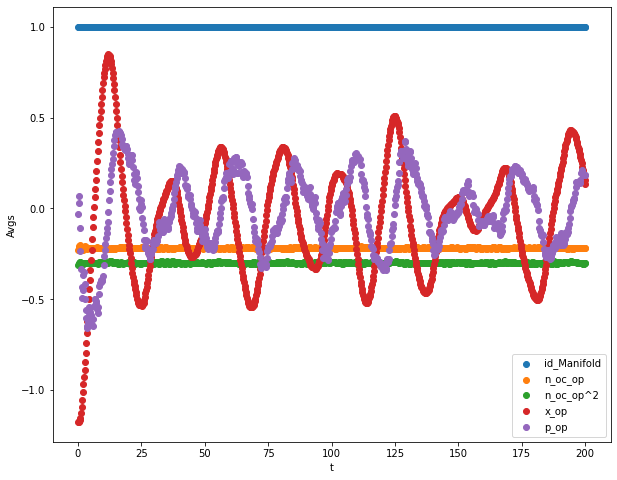

In [31]:
### dinÃ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis_orth)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


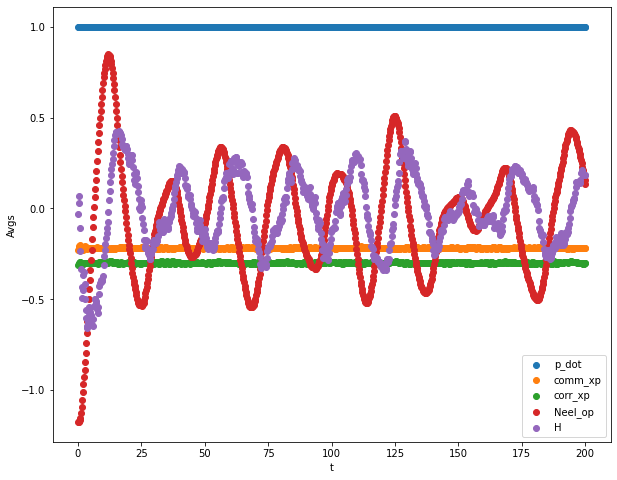

In [32]:
plt.figure(figsize=(10, 8))
for index, name in enumerate(["p_dot", "comm_xp", "corr_xp", "Neel_op", "H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

In [33]:
Htensor = me.H_ij_matrix(H_H, basis, rho0, me.HS_inner_prod_r)

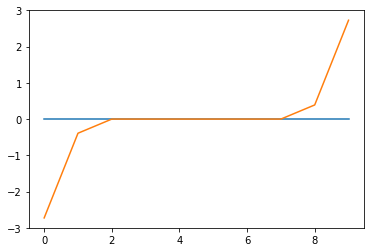

In [34]:
HijT = np.array([[me.HS_inner_prod_r(op2, -1j*(H_H*op1-op1*H_H),rho_ref) for op1 in basis_orth] for op2 in basis_orth])
HijT = (qutip.Qobj(HijT))
plt.plot(qutip.Qobj(HijT).eigenenergies().real)
plt.plot(sorted(qutip.Qobj(HijT).eigenenergies().imag))

In [59]:
ts1 = np.linspace(0, 200, 500)

Phi_vector_solution = []
Phi_vector_solution.append(np.array(phi0))

for i in range(len(ts1)-1):
    a = ( ts1[i+1] * HijT ).expm() * Phi_vector_solution[i]
    Phi_vector_solution.append(a)
    
rho_at_timet = []
rho_at_timet.append(rho0)

for i in range(len(Phi_vector_solution)):
    rhot= (-sum( f*op for f,op in zip(Phi_vector_solution[i], basis_orth))).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet.append(rhot)

for t in range(len(rho_at_timet)):
    if not me.is_density_op(rho_at_timet[t]):
        print("At time", t, "not density op")

At time 3 not density op
At time 8 not density op
At time 18 not density op
At time 22 not density op
At time 24 not density op
At time 27 not density op
At time 30 not density op
At time 31 not density op
At time 35 not density op
At time 36 not density op
At time 48 not density op
At time 55 not density op
At time 59 not density op
At time 63 not density op
At time 71 not density op
At time 76 not density op
At time 78 not density op
At time 80 not density op
At time 81 not density op
At time 82 not density op
At time 84 not density op
At time 94 not density op
At time 99 not density op
At time 101 not density op
At time 103 not density op
At time 105 not density op
At time 108 not density op
At time 111 not density op
At time 112 not density op
At time 118 not density op
At time 119 not density op
At time 120 not density op
At time 121 not density op
At time 122 not density op
At time 124 not density op
At time 126 not density op
At time 129 not density op
At time 134 not density op

/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


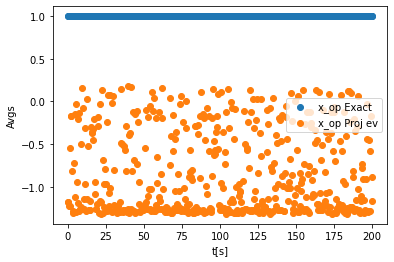

In [60]:
for index, name in enumerate(["x_op"]): #(["n_oc_op", "x_op", "p_op"])
    plt.scatter(res.times, res.expect[index], label = name + " Exact")
    
#plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")
plt.scatter(ts1, (qutip.expect(basis_orth[3], rho_at_timet)[:-1]), label = "x_op Proj ev")
#plt.scatter(ts1, (qutip.expect(cl_ops["p_op"], rho_at_timet)[:-1]), label = "p_op Proj ev")

plt.xlabel("t[s]")
plt.ylabel("Avgs")
plt.legend()

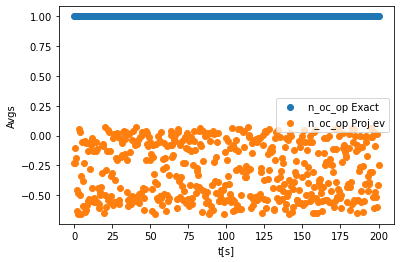

In [62]:
for index, name in enumerate(["n_oc_op"]):#, "x_op", "p_op"]):
    plt.scatter(res.times, res.expect[index], label = name + " Exact")
    
plt.scatter(ts1, (qutip.expect(basis_orth[1], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")

plt.xlabel("t[s]")
plt.ylabel("Avgs")
plt.legend()

In [63]:
me.bures(rho_ref, rho0)

0.2598548586441649

In [64]:
me.bures(rho_ref, rho_at_timet[500])

0.2256526986691246